<a href="https://colab.research.google.com/github/soaresbru/bootcamp-Unimed-Data-science/blob/main/cachorro_ou_gato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Redes Neurais: Saber se é cachorro ou gato

Neste notebook serão realizadas as principais etapas para aplicar redes neurais para saber se uma imagem é de cachorro ou gato, o ideia é ver qual será um quantidade pequena de dados que dá para ver que a rede está aprendendo e não apenas um chute.

Os dados para realizar esse notebook foram retirados do Kaggle: https://www.kaggle.com/competitions/dogs-vs-cats


Como todas as imagens juntas era demais, levaria muito tempo para o processamento  
Então decidi fazer com cerca de 300 imagens de gatos e 300 imagens de cachorro, mas eram poucas imagens e o modelo não conseguiu aprender.   
Depois com cerca de 700 imagens de gatos e 700 imagens de cachorro o modelo começou a aprender bem

## Conteúdo
1. Importando as bibliotecas
2. Leitura das bases consumidas
3. Manipulando os dados de treino
4. Construindo o modelo
5. Criando Callback
6. Dividindo em treino e validação
7. Data Augmentation
8. Treinando o modelo
9. Avaliando mais o modelo
10. Aplicando aos dados de treino
11. Conclusão

## 1. Importando as bibliotecas

Nesta etapa, todas as biliotecas usadas no notebook serão importadas



In [1]:
# importando as bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importando a biblioteca para carregar arquivos do drive
from google.colab import drive

# Importando bibliotecas referentes as redes neurais
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Importando outras bibliotecas uteis
from sklearn.model_selection import train_test_split
import os
import random

#importando bibliotecas de métricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## 2. Leitura das bases consumidas
Nesta etapa, a base de dados será lida



In [2]:
# Montando Google Drive
drive.mount('/content/drive')

# Caminho para pegar os arquivos do drive
caminho = '/content/drive/MyDrive/Dataset - projetos dados/dogs-vs-cats/treino'  

# Importando também o arquivo de teste
test_filenames = os.listdir("/content/drive/MyDrive/Dataset - projetos dados/dogs-vs-cats/teste")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. Manipulando os dados de treino
Nesta etapa, vamos convencionar 0 para gato e o número 1 para cachorro, e ainda contar quantos dados temos de cada



In [3]:
# Agora vamos separar as fotos que são referentes aos cachorros ou gatos
nome_arquivos = os.listdir(caminho)
tipos = []
for nome_arquivo in nome_arquivos:
    tipo = nome_arquivo.split('.')[0]
    if tipo == 'cat':
        tipos.append(0)
    else:
        tipos.append(1)

df = pd.DataFrame({
    'nome_arquivo': nome_arquivos,
    'tipo': tipos
})

In [4]:
# Olhando se a tabela está certinha
df.head()

,nome_arquivo,tipo
0,cat.460.jpg,0
1,cat.46.jpg,0
2,cat.461.jpg,0
3,cat.462.jpg,0
4,cat.463.jpg,0


In [5]:
# Contando os valores de cada tipo para ver se está certo
df['tipo'].value_counts()

0    701
1    700
Name: tipo, dtype: int64

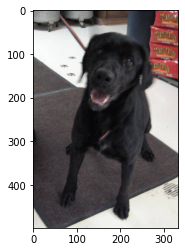

In [6]:
# Pegando uma imagem para ver se está correto
exemplo = random.choice(nome_arquivos)
image = load_img(caminho+'/'+exemplo)
plt.imshow(image)

## 4. Construindo o modelo
Nesta etapa, vamos construir o modelo e explicar alguns termos



Aqui é muito importante entender o que está sendo feito, e os termos utilizados, portanto vou passar um resumo, caso queira saber um pouco mais eu indico o canal do sandeco:  
 https://www.youtube.com/c/canalsandeco  
 Em especial a playlist de redes convolucionais


**Dropout**- ajuda a regularizar(generalizar) a rede neural, "escondendo neuronios"   
**Flatten** - Converte imagem em dado estruturado   
**Activation** - São essenciais para dar capacidade representativa às redes neurais    
**Pooling** - Serve para reduzir a imagem  
**Padding** - Serve para o output da convolução ficar no tamanho original  
**BatchNormalization** - A normalização em lote é um método usado para tornar o treinamento de redes neurais artificiais mais rápido e estável por meio da normalização das entradas das camadas

In [7]:
# O modelo pode não entender muito bem caso o tamanho das imagens seja diferente, então vamos deixar iguais
FAST_RUN = False
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [8]:

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax')) # 2 pois temos dois tipos: cão e gato

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     2

Podemos criar um Callback, para o programa parar quando chega ao estado desejado.

## 5. Criando Callback
Nesta etapa, vamos criar um Callback, para o programa parar quando chega ao estado desejado.



In [10]:
earlystop = EarlyStopping(patience=10)

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [12]:
callbacks = [earlystop, learning_rate_reduction]

In [13]:
df["tipo"] = df["tipo"].replace({0: 'cat', 1: 'dog'}) 

## 6. Dividindo em treino e validação.



In [14]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=0)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [15]:
train_df['tipo'].value_counts()

dog    564
cat    556
Name: tipo, dtype: int64

In [16]:
validate_df['tipo'].value_counts()

cat    145
dog    136
Name: tipo, dtype: int64

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=16

## 7. Data Augmentation
Nesta etapa, vamos "aumentar" a quantidade de dados modificando uma imagem, mudando por exemplo a rotação, o brilho, o zoom, espelhando, entre outros.



In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    caminho, 
    x_col='nome_arquivo',
    y_col='tipo',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1120 validated image filenames belonging to 2 classes.


In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    caminho, 
    x_col='nome_arquivo',
    y_col='tipo',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 281 validated image filenames belonging to 2 classes.


In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    caminho, 
    x_col='nome_arquivo',
    y_col='tipo',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


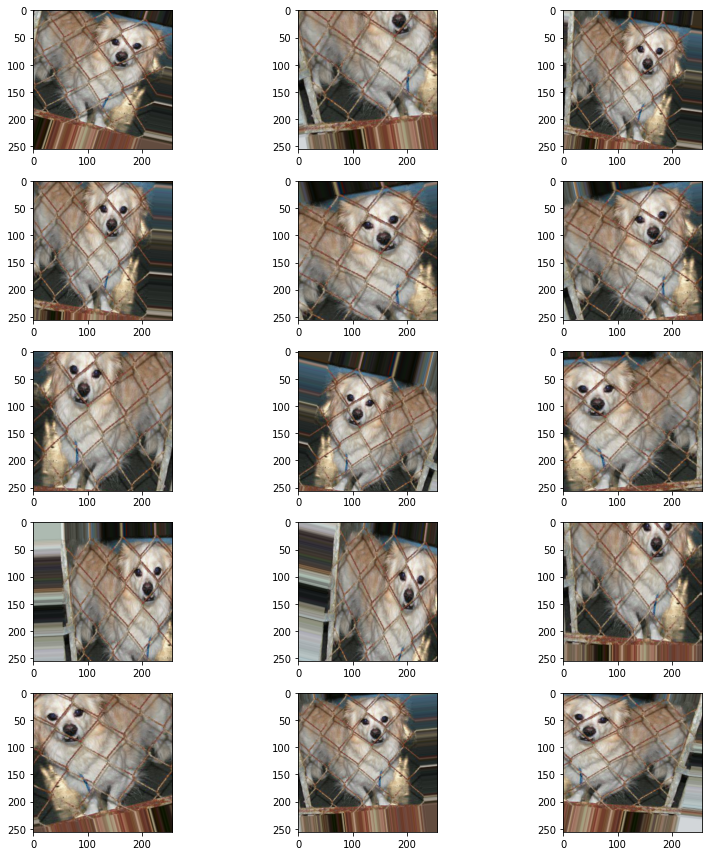

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## 8. Treinando o modelo
Nesta etapa, vamos de fato fazer com que a rede neural aprenda e avaliar esse aprendizado



In [22]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
70/70 [==============================] - 33s 330ms/step - loss: 1.4142 - accuracy: 0.5625 - val_loss: 1.4045 - val_accuracy: 0.5147 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 21s 306ms/step - loss: 0.9863 - accuracy: 0.5473 - val_loss: 0.8120 - val_accuracy: 0.4632 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - ETA: 0s - loss: 0.8315 - accuracy: 0.5759
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
70/70 [==============================] - 23s 325ms/step - loss: 0.8315 - accuracy: 0.5759 - val_loss: 0.7603 - val_accuracy: 0.4596 - lr: 0.0010
Epoch 4/50
70/70 [==============================] - 23s 323ms/step - loss: 0.7108 - accuracy: 0.6223 - val_loss: 1.2709 - val_accuracy: 0.5147 - lr: 5.0000e-04
Epoch 5/50
70/70 [==============================] - 22s 307ms/step - loss: 0.6825 - accuracy: 0.6223 - val_loss: 0.7831 - val_accuracy: 0.5221 - lr: 5.0000e-04
Epoch 6/50
70/70 [==============================] - 2

In [23]:
# Salvando o modelo
model.save_weights("model.h5")

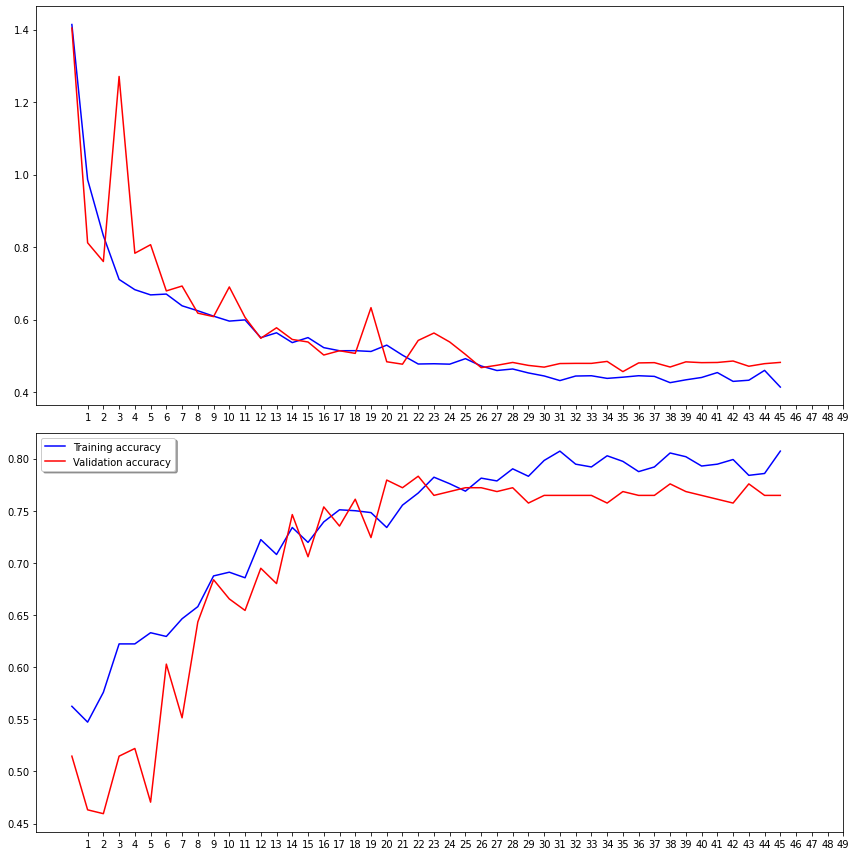

In [24]:
# Avaliando o modelo por meio de gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [25]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test: accuracy = 0.761029  ;  loss = 0.481082 


## 9. Avaliando mais o modelo
Nesta etapa, vamos avaliar ainda mais o modelo com matriz de confusão e classification report



In [126]:
validate_df["tipo"] = validate_df["tipo"].replace({ 1: 'dog', 0: 'cat' })
Y_val = validate_df['tipo']

y_pred =  model.predict(validation_generator, steps=np.ceil(total_validate/batch_size))

18/18 [==============================] - 1s 74ms/step


In [127]:
validate_df['y_pred'] = np.argmax(y_pred, axis = -1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())

validate_df['y_pred'] = validate_df['y_pred'].replace(label_map)

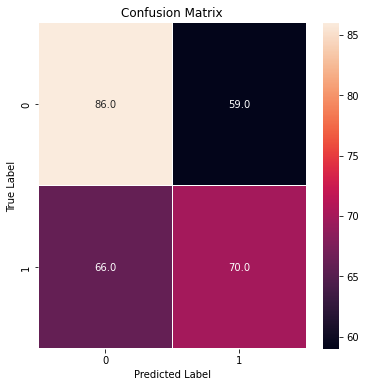

In [128]:
# Utilizando a matriz de confusão
confusion_mtx = confusion_matrix(validate_df["tipo"], validate_df['y_pred']) 
# plotando a matriz
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matriz de Confusão")
plt.show()

In [130]:
# Mostrando o classification report
report = classification_report(validate_df["tipo"], validate_df['y_pred'], target_names=['0','1'])

print(report)

              precision    recall  f1-score   support

           0       0.57      0.59      0.58       145
           1       0.54      0.51      0.53       136

    accuracy                           0.56       281
   macro avg       0.55      0.55      0.55       281
weighted avg       0.55      0.56      0.55       281



## 10. Aplicando aos dados de treino
Nesta etapa, vamos fazer os passos que fizemos anteriormente nos dados de treino para os dados de teste



In [50]:
test_df = pd.DataFrame({
    'nome_arquivo': test_filenames
})
nb_samples = test_df.shape[0]

In [51]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/MyDrive/Dataset - projetos dados/dogs-vs-cats/teste", 
    x_col='nome_arquivo',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 250 validated image filenames.


In [52]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [54]:
test_df['tipo'] = np.argmax(predict, axis=-1)

In [55]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['tipo'] = test_df['tipo'].replace(label_map)

In [56]:
test_df['tipo'] = test_df['tipo'].replace({ 'dog': 1, 'cat': 0 })

## 11. Conclusão
Nesta etapa, vamos fazer concluir, fazendo a avaliação do teste, falar dos próximos passos e agradecer



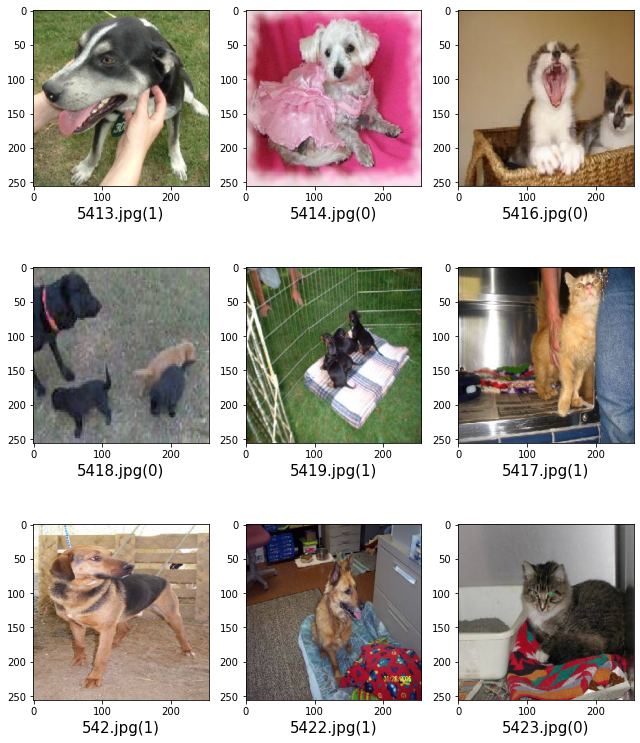

In [64]:
sample_test = test_df.head(9)
sample_test.head()
plt.figure(figsize=(9, 11))
for index, row in sample_test.iterrows():
    filename = row['nome_arquivo']
    category = row['tipo']
    img = load_img("/content/drive/MyDrive/Dataset - projetos dados/dogs-vs-cats/teste/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' , fontsize = 15)
plt.tight_layout()
plt.show()

Lembrando que gato é igual a 0, e cachorro é igual 1  
Nesse dados de teste nosso modelo acertou 6 de 9, ou seja, 66%  
Então condiz com os nossos dados treino e validação

Para os próximos passos o ideal seria treinar com mais dados

Gostaria de agradecer ao  https://www.kaggle.com/uysimty  
Ele fez um ótimo trabalho e me ajudou na conclusão desse, quem quiser olhar o trabalho dele, aqui está o link:
https://www.kaggle.com/code/uysimty/keras-cnn-dog-or-cat-classification
